In [9]:
# Import packages
import pandas as pd
import numpy as np
import os
import glob
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Customer Lifecycle Value Analysis

In [10]:
# Load processed data
entries_df = pd.read_csv('processed_contest_entries.csv')

In [11]:
# Calculate customer lifecycle metrics
entries_df['Date'] = pd.to_datetime(entries_df['Date'])  # Ensure 'Date' column is in datetime format
user_history = entries_df.sort_values(['EntryName', 'Date'])
user_history['EntryCount'] = user_history.groupby('EntryName').cumcount() + 1
user_history['DaysSinceFirstEntry'] = (user_history['Date'] - user_history.groupby('EntryName')['Date'].transform('min')).dt.days

In [12]:
# Create lifecycle cohorts
user_history['EntryCountBucket'] = pd.cut(
    user_history['EntryCount'], 
    bins=[0, 1, 3, 5, 10, 20, 50],
    labels=['First Entry', '2-3 Entries', '4-5 Entries', '6-10 Entries', 
            '11-20 Entries', '21-50 Entries']
)

In [26]:
# Calculate key metrics by lifecycle stage
lifecycle_metrics = user_history.groupby('EntryCountBucket', observed=True).agg({
    'EntryName': 'nunique',
    'EntryFee': ['mean', 'sum'],
    'Points': 'mean',
    'Rank': ['mean', lambda x: (x <= x.quantile(0.1)).mean()]  # % of entries in top 10%
}).reset_index()

lifecycle_metrics.columns = ['EntryCountBucket', 'UniqueUsers', 'AvgEntryFee', 'TotalSpend', 
                            'AvgPoints', 'AvgRank', 'Top10PctRate']

lifecycle_metrics

,EntryCountBucket,UniqueUsers,AvgEntryFee,TotalSpend,AvgPoints,AvgRank,Top10PctRate
0,First Entry,715197,4.912253,3513228.75,250.008369,21992.687488,0.100075
1,2-3 Entries,266770,4.511234,1845586.50,250.148350,19891.632731,0.100005
2,4-5 Entries,86589,4.424117,624442.00,244.737105,17923.012951,0.100018
3,6-10 Entries,35108,4.597764,433242.75,245.766478,15400.036708,0.100033
4,11-20 Entries,6331,2.830134,81468.25,243.747169,13504.514278,0.100083
5,21-50 Entries,778,2.296738,13059.25,243.181147,9580.612733,0.101829


In [28]:
# Calculate retention rates between lifecycle stages
user_max_stage = user_history.groupby('EntryName')['EntryCountBucket'].max().reset_index()
stage_counts = user_max_stage['EntryCountBucket'].value_counts().sort_index()
retention_rates = (stage_counts / stage_counts.shift(1) * 100).fillna(100)

In [29]:
# Calculate average spend per user at each stage
total_spend_by_stage = user_history.groupby(['EntryName', 'EntryCountBucket'], observed=True)['EntryFee'].sum()
avg_spend_per_user = total_spend_by_stage.groupby('EntryCountBucket', observed=True).mean()
avg_spend_per_user

EntryCountBucket
First Entry       4.912253
2-3 Entries       6.918269
4-5 Entries       7.211563
6-10 Entries     12.340286
11-20 Entries    12.868149
21-50 Entries    16.785668
Name: EntryFee, dtype: float64

In [16]:
# Business Insight: Identify the critical retention points
critical_stages = retention_rates[retention_rates < 50].index
print(f"Critical retention drop-off points: {critical_stages.tolist()}")

Critical retention drop-off points: ['2-3 Entries', '4-5 Entries', '11-20 Entries', '21-50 Entries']


In [17]:
# Business Insight: Calculate CLV by stage
clv_by_stage = lifecycle_metrics.set_index('EntryCountBucket')
clv_by_stage['CumulativeValue'] = lifecycle_metrics['TotalSpend'].cumsum() / lifecycle_metrics['UniqueUsers'].iloc[0]

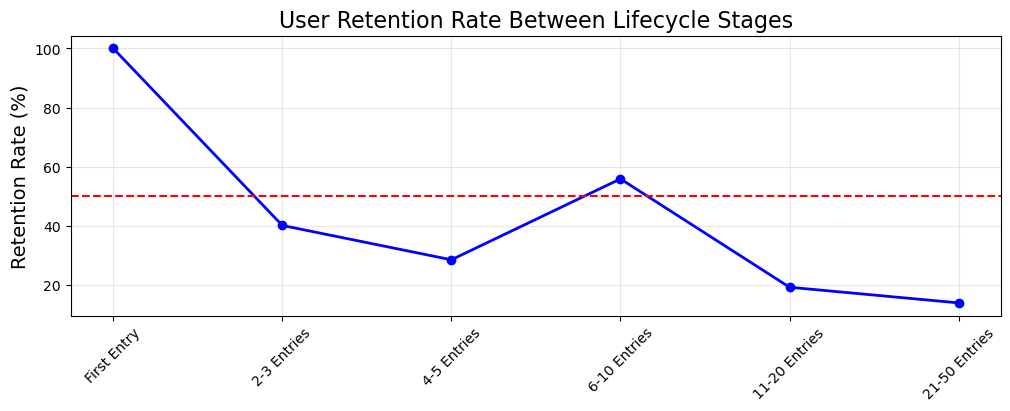

In [21]:
# Visualize customer lifecycle value
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(retention_rates.index, retention_rates.values, 'bo-', linewidth=2)
plt.axhline(y=50, color='red', linestyle='--')
plt.title('User Retention Rate Between Lifecycle Stages', fontsize=16)
plt.ylabel('Retention Rate (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.savefig('customer_lifecycle_analysis.png', dpi=300)

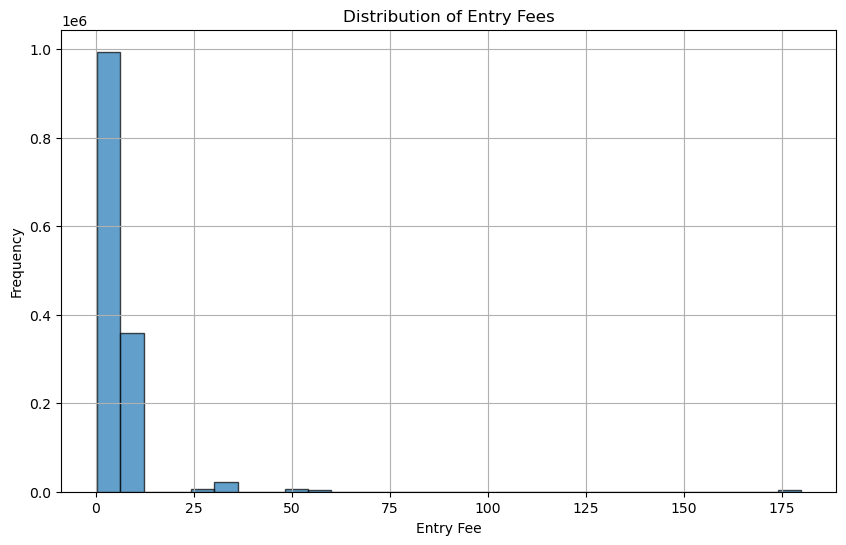

In [30]:
# Plot histogram of the distribution of entry fees
plt.figure(figsize=(10, 6))
plt.hist(entries_df['EntryFee'], bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Entry Fees')
plt.xlabel('Entry Fee')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()